# Visualize GRN

Notebook visualize regvelo-inferred cell cycle core GRN

## Library imports

In [1]:
import networkx as nx
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import anndata as ad
import scvelo as scv
import scvi
from regvelo import REGVELOVI

from rgv_tools import DATA_DIR, FIG_DIR
from rgv_tools.perturbation import inferred_GRN

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_t

## General settings

In [2]:
%matplotlib inline

In [3]:
plt.rcParams["svg.fonttype"] = "none"

In [4]:
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=14, color_map="viridis")

In [5]:
scvi.settings.seed = 0

[rank: 0] Seed set to 0


## Constants

In [6]:
DATASET = "cell_cycle"

In [7]:
SAVE_DATA = True
SAVE_FIGURES = True

if SAVE_DATA:
    (DATA_DIR / DATASET / "results").mkdir(parents=True, exist_ok=True)
if SAVE_FIGURES:
    (FIG_DIR / DATASET / "results").mkdir(parents=True, exist_ok=True)

## Data loading

In [8]:
adata = ad.io.read_h5ad(DATA_DIR / DATASET / "processed" / "adata_processed.h5ad")
TF = pd.read_csv(DATA_DIR / DATASET / "raw" / "allTFs_hg38.txt", header=None)
TF = adata.var_names[adata.var_names.isin(TF.iloc[:, 0])]

adata

AnnData object with n_obs × n_vars = 1146 × 395
    obs: 'phase', 'fucci_time', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'ensum_id', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'log1p', 'neighbors', 'pca', 'umap', 'velocity_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs', 'true_skeleton'
    layers: 'Ms', 'Mu', 'spliced', 'total', 'unspliced', 'velocity'
    obsp: 'connectivities', 'distances'

## Model loading

In [9]:
vae = REGVELOVI.load(DATA_DIR / DATASET / "regvelo_model", adata)

INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/cell_cycle/regvelo_model/model.pt already         
         downloaded                                                                                                


## Identify most activate TF

In [10]:
adata.obs["cluster"] = "0"  ## create label with one-class because of it is cell line dataset
GRN = inferred_GRN(vae, adata, label="cluster", group="all")
pd.DataFrame((GRN[:, adata.var.index.isin(TF)]).mean(0), index=adata.var.index[adata.var.index.isin(TF)]).sort_values(
    0, ascending=False
).iloc[:10, :]

Computing global GRN...


,0
TGIF1,1.025551
ETV7,0.316861
ETV1,0.300762
KLF7,0.192435
ARID5B,0.153252
EGR1,0.140843
KIF22,0.044913
EBF1,0.018076
SMAP2,-0.000480
ZSCAN4,-0.024477


## GRN processing pipeline

In [11]:
## Detect regulon for TGIF1
targets = GRN[:, [i == "TGIF1" for i in adata.var.index]].reshape(-1)

targets = pd.DataFrame(targets, index=adata.var.index)
targets.loc[:, "weight"] = targets.iloc[:, 0].abs()

GRN_visualize_tgif1 = targets.sort_values("weight", ascending=False).iloc[:50, :]

## Detect regulon for ETV1
targets = GRN[:, [i == "ETV1" for i in adata.var.index]].reshape(-1)

targets = pd.DataFrame(targets, index=adata.var.index)
targets.loc[:, "weight"] = targets.iloc[:, 0].abs()

GRN_visualize_etv1 = targets.sort_values("weight", ascending=False).iloc[:50, :]

## processing GRN
df1 = pd.DataFrame({"from": ["TGIF1"] * 50, "to": GRN_visualize_tgif1.index.tolist()})

df2 = pd.DataFrame({"from": ["ETV1"] * 50, "to": GRN_visualize_etv1.index.tolist()})
df = pd.concat([df1, df2], axis=0)
list1 = ["TGIF1"] + GRN_visualize_tgif1.index.tolist()
list2 = ["ETV1"] + GRN_visualize_etv1.index.tolist()

# Define communities
community1 = list(set(list1) - set(list2))  # Nodes only in list1
community2 = list(set(list2) - set(list1))  # Nodes only in list2
community3 = list(set(list1).intersection(list2))  # Nodes shared by both
communities = [frozenset(set(community1)), frozenset(set(community2)), frozenset(set(community3))]

# return GRN
G = nx.from_pandas_edgelist(df, source="from", target="to", create_using=nx.DiGraph())

## GRN visualization

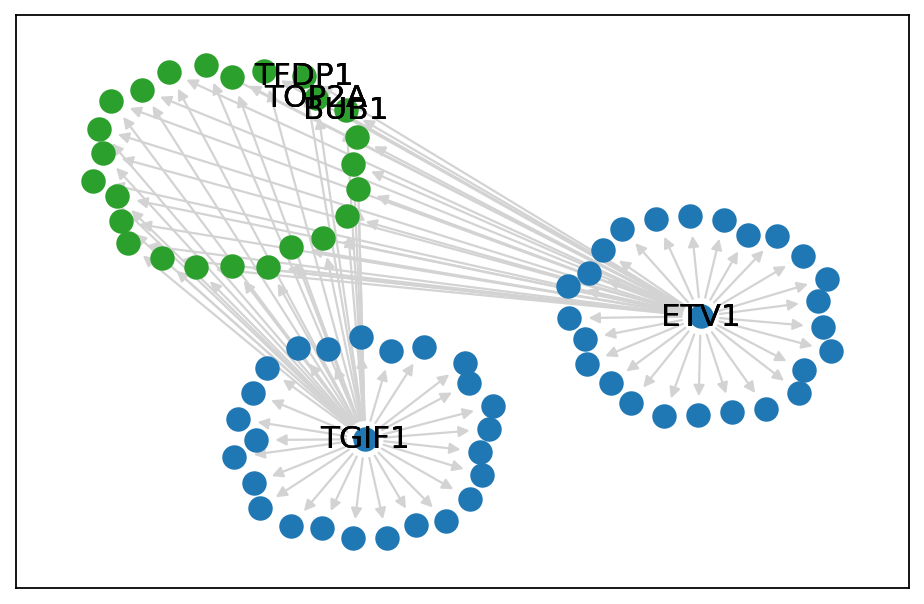

In [12]:
if SAVE_FIGURES:
    fig, ax = plt.subplots(figsize=(6, 4))
    supergraph = nx.cycle_graph(len(communities))
    superpos = nx.spring_layout(G, scale=3)

    # Use the "supernode" positions as the center of each node cluster
    centers = list(superpos.values())
    pos = {}
    for center, comm in zip(centers, communities):
        pos.update(nx.spring_layout(nx.subgraph(G, comm), center=center))

    # Nodes colored by cluster
    node_list = ["TGIF1", "ETV1", "BUB1", "TOP2A", "TFDP1"]
    for nodes, clr in zip(communities, ("tab:blue", "tab:blue", "tab:green")):
        nx.draw_networkx_nodes(G, pos=pos, nodelist=nodes, node_color=clr, node_size=100)
        nx.draw_networkx_labels(G, pos=pos, labels={node: node for node in node_list}, font_size=14, font_color="black")
    nx.draw_networkx_edges(G, pos=pos, edge_color="lightgrey")

    plt.tight_layout()

    fig.savefig(FIG_DIR / DATASET / "O2SC_GRN.svg", format="svg", transparent=True, bbox_inches="tight")
    plt.show()